In [1]:
import os
import cv2
import torch
# import numpy as np
# import pybboxes as pbx
from dataset import VOCDataset
import torchvision.transforms as transforms
import torch.optim as optim
from model import Yolov1, YOLOv1ResNet, YOLO_V1_HeadV2_ResNet
from utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image_2,
    save_checkpoint,
    load_checkpoint
)
import opencv_jupyter_ui as jcv2
import random
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
EXP_NAME = "voc_aug_res34_final"
LEARNING_RATE = 1e-5
DEVICE = "cpu"
BATCH_SIZE = 5
WEIGHT_DECAY = 0.0005
EPOCHS = 150
NUM_WORKERS = 1
PIN_MEMORY = False
LOAD_MODEL = False
LOAD_MODEL_FILE = f"checkpoints/{EXP_NAME}.pth.tar"
DATA_DIR = "data"
IMG_DIR = f"{DATA_DIR}/images"
LABEL_DIR = f"{DATA_DIR}/labels"
CLASSES = 20
CELL_SPLIT = 7

In [3]:
# model = Yolov1(split_size=CELL_SPLIT, num_boxes=2, num_classes=CLASSES).to(DEVICE)
model = YOLOv1ResNet(backbone_name="resnet34", S=CELL_SPLIT, B=2, C=CLASSES).to(DEVICE)
# model = YOLO_V1_HeadV2_ResNet(backbone_name="resnet34", S=CELL_SPLIT, B=2, C=CLASSES).to(DEVICE)
optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

=> Loading checkpoint


In [4]:
labels = {
    0:'aeroplane',
    1:'bicycle',
    2:'bird',
    3:'boat',
    4:'bottle',
    5:'bus',
    6:'car',
    7:'cat',
    8:'chair',
    9:'cow',
    10:'diningtable',
    11:'dog',
    12:'horse',
    13:'motorbike',
    14:'person',
    15:'pottedplant',
    16:'sheep',
    17:'sofa',
    18:'train',
    19:'tvmonitor',
}

In [5]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes
        
        return img, bboxes

# add normalization
transforms = Compose(
    [
        transforms.Resize((448, 448)), 
        transforms.ToTensor(), 
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

In [6]:
# train_dataset = VOCDataset(
#     f"{DATA_DIR}/train_aug.csv",  # 100examples.csv for quick checks
#     transform=transforms,
#     img_dir=IMG_DIR,
#     label_dir=f"{DATA_DIR}/labels/",
#     C=CLASSES,
#     S=CELL_SPLIT
# )

# val_dataset = VOCDataset(
#     f"{DATA_DIR}/val.csv",
#     transform=transforms,
#     img_dir=IMG_DIR,
#     label_dir=f"{DATA_DIR}/labels/",
#     C=CLASSES,
#     S=CELL_SPLIT
# )

# test_dataset = VOCDataset(
#     f"{DATA_DIR}/test.csv",
#     transform=transforms,
#     img_dir=IMG_DIR,
#     label_dir=f"{DATA_DIR}/labels/",
#     C=CLASSES,
#     S=CELL_SPLIT
# )

# train_loader = torch.utils.data.DataLoader(
#     dataset=train_dataset,
#     batch_size=BATCH_SIZE,
#     # num_workers=NUM_WORKERS,
#     pin_memory=PIN_MEMORY,
#     shuffle=True,
#     drop_last=True,
# )

# val_loader = torch.utils.data.DataLoader(
#     dataset=val_dataset,
#     batch_size=BATCH_SIZE,
#     # num_workers=NUM_WORKERS,
#     pin_memory=PIN_MEMORY,
#     shuffle=True,
#     drop_last=True,
# )

# test_loader = torch.utils.data.DataLoader(
#     dataset=test_dataset,
#     batch_size=BATCH_SIZE,
#     # num_workers=NUM_WORKERS,
#     pin_memory=PIN_MEMORY,
#     shuffle=True,
#     drop_last=True,
# )

In [7]:
def create_compare_dataloader(type):
    df = pd.read_csv(f"{DATA_DIR}/{type}.csv", names=["images", "labels"]).sample(n=5)
    # print(df)
    df.to_csv(f"{DATA_DIR}/{type}_compare.csv", index=False, header=None)
    dataset = VOCDataset(
        f"{DATA_DIR}/{type}_compare.csv",
        transform=transforms,
        img_dir=IMG_DIR,
        label_dir=f"{DATA_DIR}/labels/",
        C=CLASSES,
        S=CELL_SPLIT
    )
    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=BATCH_SIZE,
        # num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
    )

    return dataloader


# def plot_img(img, image_bbox, output_type):
#     img_np = np.array(img)
#     img = cv2.UMat(img_np)
#     H, W = img_np.shape[:2]
#     for bbox in image_bbox:
#         class_lbl, x, y, w, h = bbox
#         box_voc = pbx.convert_bbox((x,y,w,h), from_type="yolo", to_type="voc", image_size=(W,H))
#         cv2.rectangle(img, (box_voc[0], box_voc[1]), (box_voc[2], box_voc[3]), (0, 0, 255), 2)
#         cv2.rectangle(img, (box_voc[0]+3, box_voc[1]+5), (box_voc[0]+len(labels[class_lbl])*12, box_voc[1]+18+5), color=(255, 255, 255), thickness=cv2.FILLED)
#         cv2.putText(img, f"{labels[class_lbl]}", (box_voc[0]+5, box_voc[1]+18), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,192,203), 2)
#     jcv2.imshow(output_type, img.get())
#     # jcv2.waitKey(0)
#     jcv2.destroyAllWindows()


def evaluate(loader):
    for batch_idx, (x, y) in enumerate(loader):
        for idx in range(BATCH_SIZE):
            bboxes_gt = cellboxes_to_boxes(y[idx].unsqueeze(0))[0]
            bboxes_gt = non_max_suppression(bboxes_gt, iou_threshold=0.5, threshold=0.4, box_format="midpoint")
            print("Ground Truth")
            plot_image_2(x[idx].permute(1,2,0).to("cpu"), bboxes_gt)
            bboxes_pred = cellboxes_to_boxes(model(x))
            bboxes_pred_1 = non_max_suppression(bboxes_pred[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
            bboxes_pred_2 = non_max_suppression(bboxes_pred[idx], iou_threshold=0.6, threshold=0.5, box_format="midpoint")
            bboxes_pred_3 = non_max_suppression(bboxes_pred[idx], iou_threshold=0.7, threshold=0.5, box_format="midpoint")
            print("Prediction with IOU Threshold = 0.5, removal_threshold = 0.4")
            plot_image_2(x[idx].permute(1,2,0).to("cpu"), bboxes_pred_1)
            print("Prediction with IOU Threshold = 0.6, removal_threshold = 0.5")
            plot_image_2(x[idx].permute(1,2,0).to("cpu"), bboxes_pred_2)
            print("Prediction with IOU Threshold = 0.7, removal_threshold = 0.6")
            plot_image_2(x[idx].permute(1,2,0).to("cpu"), bboxes_pred_3)
            break
        break

Ground Truth


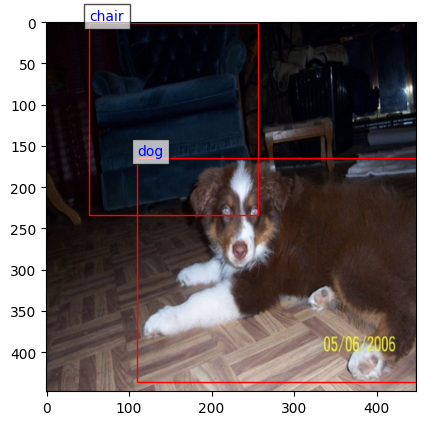

Prediction with IOU Threshold = 0.5, removal_threshold = 0.4


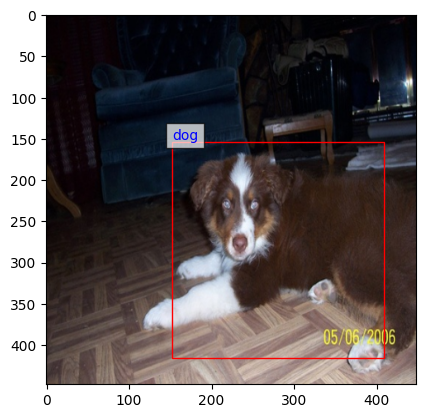

Prediction with IOU Threshold = 0.6, removal_threshold = 0.5


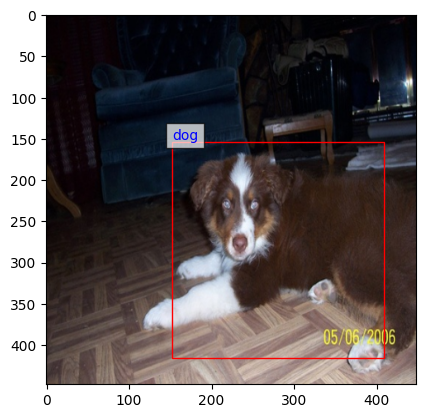

Prediction with IOU Threshold = 0.7, removal_threshold = 0.6


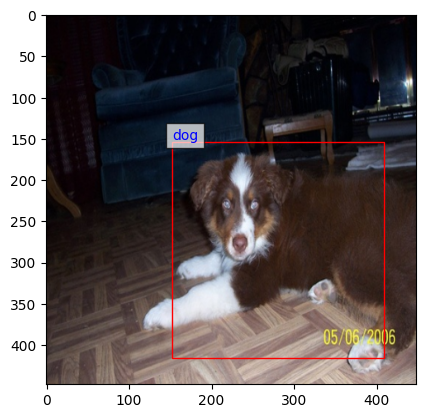

In [39]:
evaluate(create_compare_dataloader("test"))